<span style="font-family: Arial; font-weight:bold;font-size:2.1em;color:#fff;">-----------------------------------
    
<span style="font-family: Arial; font-weight:bold;font-size:2.1em;color:#fa9200;">This NB Pulls Historical Stock Data from Yahoo Finance
    
<span style="font-family: Arial; font-weight:bold;font-size:2.1em;color:#fff;">-----------------------------------

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from datetime import date, datetime
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.formula.api as sm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import yfinance as yf
from scipy.signal import argrelextrema
from collections import defaultdict

# Grab Data for Ticker

In [28]:
ticker = "XOM"
start_date = date(2000,1,1)
my_ticker = yf.Ticker(ticker)
df = my_ticker.history(period="280d", interval = "1h")
df = df.reset_index()
df['date'] = df.Datetime.dt.tz_localize(None)
df.columns = [x.lower() for x in df.columns]
#df.drop(['datetime'], axis=1, inplace=True)
df

datetime        open        high         low  \
0    2023-01-26 09:30:00-05:00  114.720001  116.120003  114.334999   
1    2023-01-26 10:30:00-05:00  115.529999  116.059998  115.129997   
2    2023-01-26 11:30:00-05:00  115.830002  116.775002  115.699997   
3    2023-01-26 12:30:00-05:00  116.739998  117.139999  116.459999   
4    2023-01-26 13:30:00-05:00  116.849998  117.400002  116.790001   
...                        ...         ...         ...         ...   
1949 2024-03-07 11:30:00-05:00  107.589996  107.599998  107.250000   
1950 2024-03-07 12:30:00-05:00  107.445000  107.559998  107.150002   
1951 2024-03-07 13:30:00-05:00  107.419998  107.510002  107.150002   
1952 2024-03-07 14:30:00-05:00  107.349998  107.419998  107.135002   
1953 2024-03-07 15:30:00-05:00  107.260002  107.529999  107.209999   

           close   volume  dividends  stock splits                date  
0     115.529900  5431006        0.0           0.0 2023-01-26 09:30:00  
1     115.839996  2002067        0.0           0.0 2023-01-26 10:30:00  
2     116.731499  2172068        0.0           0.0 2023-01-26 11:30:00  
3     116.855003  1693864        0.0           0.0 2023-01-26 12:30:00  
4     117.000000  2175529        0.0           0.0 2023-01-26 13:30:00  
...          ...      ...        ...           ...                 ...  
1949  107.455002  1586410        0.0           0.0 2024-03-07 11:30:00  
1950  107.410004  1230188        0.0           0.0 2024-03-07 12:30:00  
1951  107.339996  1359760        0.0           0.0 2024-03-07 13:30:00  
1952  107.239998  1324704        0.0           0.0 2024-03-07 14:30:00  
1953  107.370003  2373622        0.0           0.0 2024-03-07 15:30:00  

[1954 rows x 9 columns]

# Plot Data

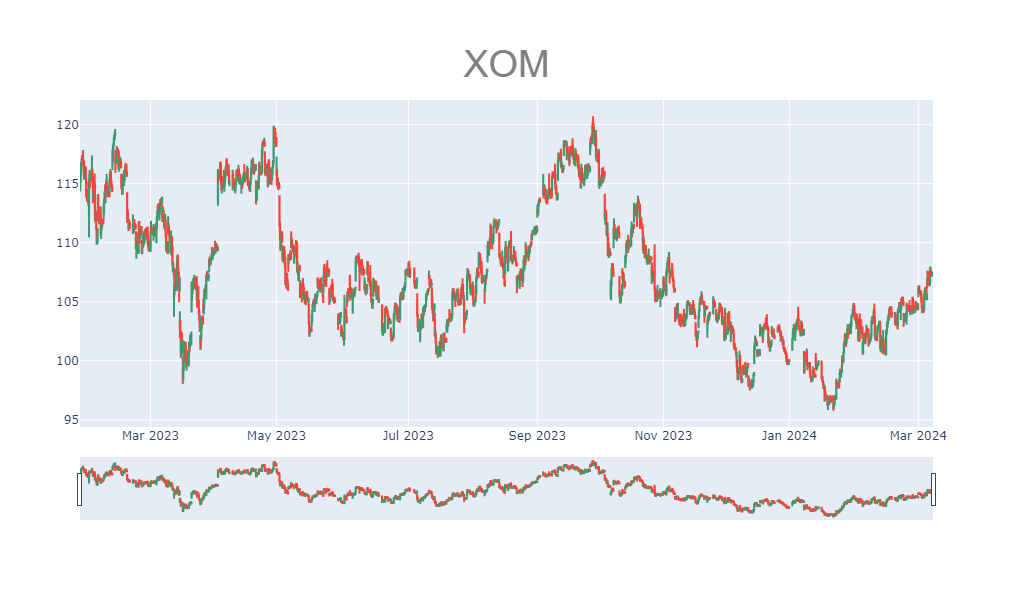

In [29]:
#df['date'] = df['date'].dt.strftime("%d-%m-%Y %H:%M:%S")
# build complete timepline from start date to end date
dt_all = pd.date_range(start=df['date'].iloc[0],end=df['date'].iloc[-1])
# retrieve the dates that ARE in the original datset
dt_obs = [d.strftime("%Y-%m-%d") for d in pd.to_datetime(df['date'])]
# define dates with missing values
dt_breaks = [d for d in dt_all.strftime("%Y-%m-%d").tolist() if not d in dt_obs]

fig = go.Figure()
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])
fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            #dict(values=["2024-12-25", "2024-01-01","2024-01-15","2024-02-19"])  # hide holidays (Christmas and New Year's, etc)
        ]
    )
fig.update_layout(title={'text':ticker, 'xanchor':'center', 'yanchor':'top','x':0.5},
                height=600,
                title_font={"family":"arial","color":"gray","size":38})
fig.show()

# Add SMAs

In [30]:
SMAs = [30,60,90]
for n in SMAs:
    df['SMA{}'.format(n)] = df['close'].rolling(window=n, center=False).mean()
df

datetime        open        high         low  \
0    2023-01-26 09:30:00-05:00  114.720001  116.120003  114.334999   
1    2023-01-26 10:30:00-05:00  115.529999  116.059998  115.129997   
2    2023-01-26 11:30:00-05:00  115.830002  116.775002  115.699997   
3    2023-01-26 12:30:00-05:00  116.739998  117.139999  116.459999   
4    2023-01-26 13:30:00-05:00  116.849998  117.400002  116.790001   
...                        ...         ...         ...         ...   
1949 2024-03-07 11:30:00-05:00  107.589996  107.599998  107.250000   
1950 2024-03-07 12:30:00-05:00  107.445000  107.559998  107.150002   
1951 2024-03-07 13:30:00-05:00  107.419998  107.510002  107.150002   
1952 2024-03-07 14:30:00-05:00  107.349998  107.419998  107.135002   
1953 2024-03-07 15:30:00-05:00  107.260002  107.529999  107.209999   

           close   volume  dividends  stock splits                date  \
0     115.529900  5431006        0.0           0.0 2023-01-26 09:30:00   
1     115.839996  2002067        0.0           0.0 2023-01-26 10:30:00   
2     116.731499  2172068        0.0           0.0 2023-01-26 11:30:00   
3     116.855003  1693864        0.0           0.0 2023-01-26 12:30:00   
4     117.000000  2175529        0.0           0.0 2023-01-26 13:30:00   
...          ...      ...        ...           ...                 ...   
1949  107.455002  1586410        0.0           0.0 2024-03-07 11:30:00   
1950  107.410004  1230188        0.0           0.0 2024-03-07 12:30:00   
1951  107.339996  1359760        0.0           0.0 2024-03-07 13:30:00   
1952  107.239998  1324704        0.0           0.0 2024-03-07 14:30:00   
1953  107.370003  2373622        0.0           0.0 2024-03-07 15:30:00   

           SMA30       SMA60       SMA90  
0            NaN         NaN         NaN  
1            NaN         NaN         NaN  
2            NaN         NaN         NaN  
3            NaN         NaN         NaN  
4            NaN         NaN         NaN  
...          ...         ...         ...  
1949  105.940389  105.210317  104.850933  
1950  105.982556  105.270317  104.883322  
1951  106.030223  105.313483  104.919322  
1952  106.075889  105.360483  104.957989  
1953  106.129223  105.409067  104.995600  

[1954 rows x 12 columns]

# Plot with SMAs

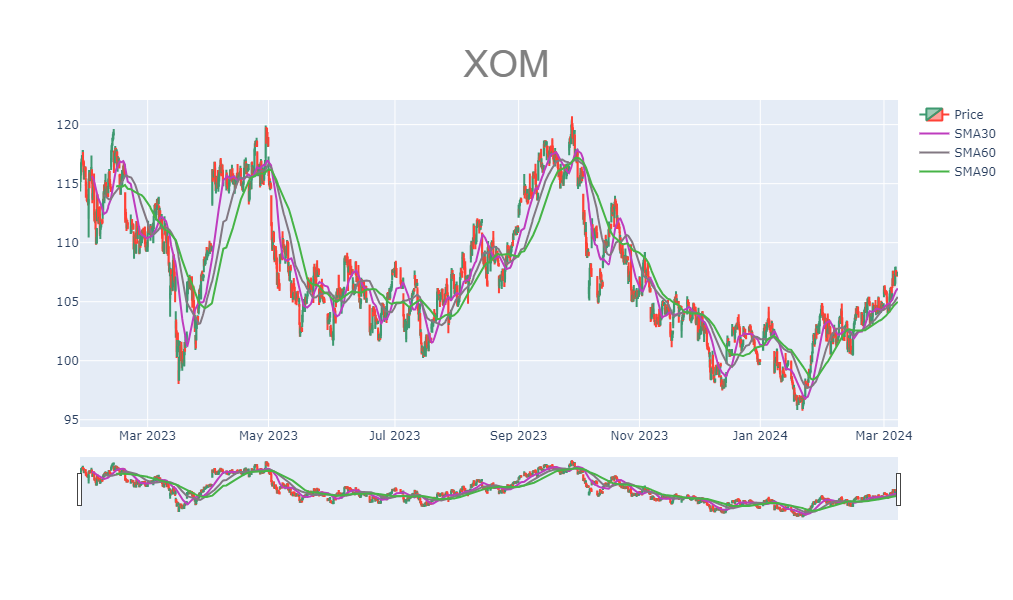

In [31]:
fig = go.Figure()
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'],
                name='Price')])
for n in SMAs:
    rgb = 'rgb({},{},{})'.format(250-n*2,n*2,250-n*2)
    fig.add_trace(go.Scatter(x=df['date'],
                y=df['SMA{}'.format(n)],
                mode='lines',
                name='SMA{}'.format(n),
                line=dict(color=rgb)))
    
fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            #dict(values=["2024-12-25", "2024-01-01","2024-01-15","2024-02-19"])  # hide holidays (Christmas and New Year's, etc)
        ]
    )
fig.update_layout(title={'text':ticker, 'xanchor':'center', 'yanchor':'top','x':0.5},
                height=600,
                title_font={"family":"arial","color":"gray","size":38})
fig.show()

# Add Local Min/Max

In [32]:
def get_max_min(prices, smoothing, window_range):
    smooth_prices = prices['close'].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['close'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['close'].idxmin())  
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    #max_min.index.name = 'date'
    max_min = max_min.reset_index(drop=True)
    #max_min = max_min[~max_min.date.duplicated()]
    #p = prices.reset_index()   
    #max_min['day_num'] = p[p['timestamp'].isin(max_min.date)].index.values
    #max_min = max_min.set_index('day_num')['close']
    
    return max_min[['date','close']]

smoothing = 10
window = 15

minmax = get_max_min(df, smoothing, window)
minmax

date       close
0   2023-01-26 15:30:00  117.760002
1   2023-02-01 09:30:00  116.139999
2   2023-02-02 13:30:00  109.949997
3   2023-02-02 13:30:00  109.949997
4   2023-02-06 12:30:00  111.654999
..                  ...         ...
230 2024-02-27 14:30:00  104.014999
231 2024-02-28 09:30:00  105.209999
232 2024-03-01 09:30:00  105.940002
233 2024-03-01 10:30:00  106.144997
234 2024-03-04 11:30:00  104.125000

[235 rows x 2 columns]

# Plot with Min/Max

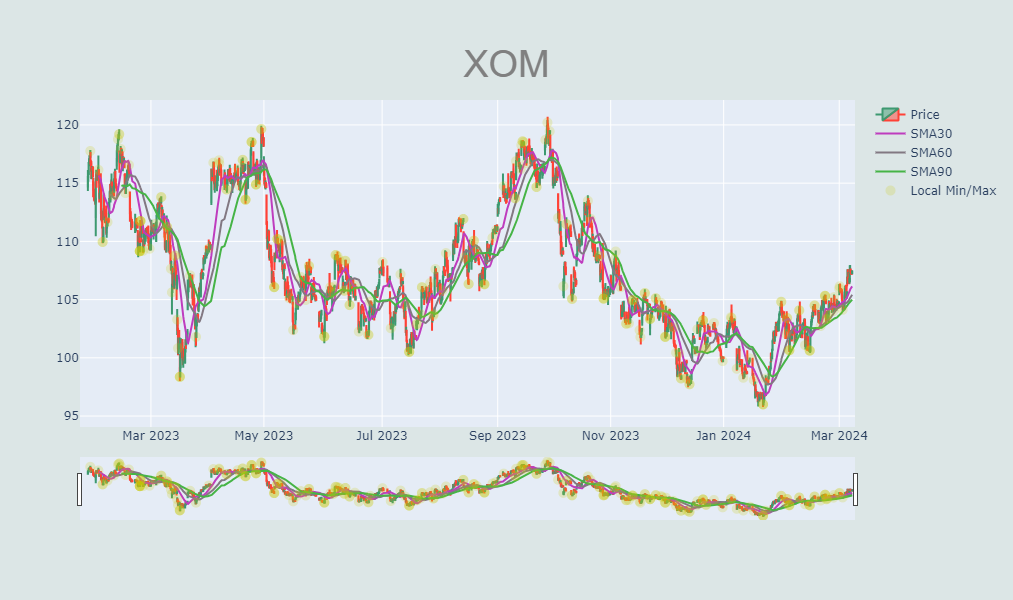

In [33]:
fig = go.Figure()
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'],
                name='Price')])
for n in SMAs:
    rgb = 'rgb({},{},{})'.format(250-n*2,n*2,250-n*2)
    fig.add_trace(go.Scatter(x=df['date'],
                y=df['SMA{}'.format(n)],
                mode='lines',
                name='SMA{}'.format(n),
                line=dict(color=rgb)))
fig.add_trace(go.Scatter(x=minmax['date'],
                y=minmax['close'],
                mode='markers',
                name='Local Min/Max',
                marker=dict(color='rgb(200,200,0)',
                            size=10,
                            opacity=0.2)
                        ))
    
fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            #dict(values=["2024-12-25", "2024-01-01","2024-01-15","2024-02-19"])  # hide holidays (Christmas and New Year's, etc)
        ]
    )
fig.update_layout(title={'text':ticker, 'xanchor':'center', 'yanchor':'top','x':0.5},
                height=600,
                title_font={"family":"arial","color":"gray","size":38},
                paper_bgcolor='rgb(220,230,230)'
                 )
fig.show()

# Add Head and Shoulders

In [66]:
def find_IHS(max_min):  
    patterns = defaultdict(list)
    
    # Window range is 5 units
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]['close']
        
        # Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > 100:      
            continue   
            
        a, b, c, d, e = window.iloc[0:5]
                
        # IHS
        if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
               patterns['IHS'].append((window.index[0], window.index[-1]))
        
    final = pd.DataFrame()
    for x,y in patterns['IHS']:
        inv_min = list(max_min[max_min.index==x]['date'])[0]
        inv_max = list(max_min[max_min.index==y]['date'])[0]
        final = pd.concat([final,pd.DataFrame({'start_hs':[inv_min],'end_hs':[inv_max]})])
        
    return final

invhs = find_IHS(minmax).reset_index(drop=True)
invhs

start_hs              end_hs
0 2023-06-26 12:30:00 2023-07-13 14:30:00
1 2023-12-21 11:30:00 2024-01-04 09:30:00

# Plot w/ H&S

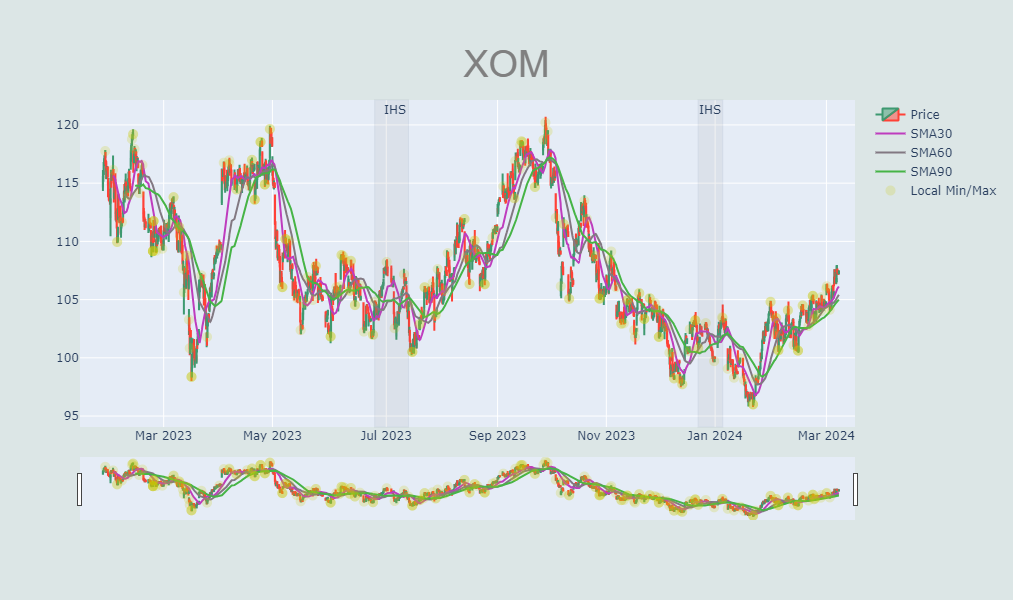

In [70]:
fig = go.Figure()
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'],
                name='Price')])
for n in SMAs:
    rgb = 'rgb({},{},{})'.format(250-n*2,n*2,250-n*2)
    fig.add_trace(go.Scatter(x=df['date'],
                y=df['SMA{}'.format(n)],
                mode='lines',
                name='SMA{}'.format(n),
                line=dict(color=rgb)))
fig.add_trace(go.Scatter(x=minmax['date'],
                y=minmax['close'],
                mode='markers',
                name='Local Min/Max',
                marker=dict(color='rgb(200,200,0)',
                            size=10,
                            opacity=0.2)
                        ))
# iterate through the shaded regions dataframe
for index, row in invhs.iterrows():
    
    # retrieve the dates
    start = row['start_hs']
    end = row['end_hs']

    # add shaded region
    fig.add_vrect(
            x0=start,
            x1=end,
            fillcolor="grey",
            opacity=0.1,
            line_width=1,
            annotation_text='IHS'
        )   
fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            #dict(values=["2024-12-25", "2024-01-01","2024-01-15","2024-02-19"])  # hide holidays (Christmas and New Year's, etc)
        ]
    )
fig.update_layout(title={'text':ticker, 'xanchor':'center', 'yanchor':'top','x':0.5},
                height=600,
                title_font={"family":"arial","color":"gray","size":38},
                paper_bgcolor='rgb(220,230,230)'
                 )
fig.show()

# Add Falling Wedge

In [75]:
def find_FW(max_min):  
    patterns = defaultdict(list)
    
    # Window range is 7 units
    for i in range(7, len(max_min)):  
        window = max_min.iloc[i-7:i]['close']
        
        # Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > 100:      
            continue   
            
        a, b, c, d, e, f, g = window.iloc[0:7]
        
        m = (g-a)/7
        x1 = i-7
        b = a - x1*m
        def lower_line(x):
            y = m*x+b
            
            return y
            
        m = (f-b)/5
        x1 = i-6
        b = a - x1*m
        def upper_line(x):
            y = m*x+b
            
            return y
                
        # FW
        c1 = lower_line(c)
        e1 = lower_line(e)
        d1 = upper_line(d)
        if (a<b and c<a and a<d and d<b and e<d and e<c and e<f and f<d and g<e and
            abs(c1-c)<=np.mean([c1,c])*0.02 and abs(e1-e)<=np.mean([e1,e])*0.02 and
            abs(d1-d)<=np.mean([d1,d])*0.02):
               patterns['FW'].append((window.index[0], window.index[-1]))
        
    final = pd.DataFrame()
    for x,y in patterns['FW']:
        inv_min = list(max_min[max_min.index==x]['date'])[0]
        inv_max = list(max_min[max_min.index==y]['date'])[0]
        final = pd.concat([final,pd.DataFrame({'start_fw':[inv_min],'end_fw':[inv_max]})])
        
    return final

fw = find_FW(minmax).reset_index(drop=True)
fw

Empty DataFrame
Columns: []
Index: []